This notebook is an addition to the sql code from the two files in order to train a model to assess the likelihood of subscribing to a deposit, it also performs basic EDA on some features of the dataset.

1. Import Libraries

In [21]:
import pandas as pd
import psycopg2
import seaborn as sns
import matplotlib.pyplot as plt
from xgboost import XGBClassifier
from sklearn.metrics import classification_report, confusion_matrix
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import OneHotEncoder
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from imblearn.pipeline import Pipeline as ImbPipeline
from imblearn.over_sampling import SMOTE
from sklearn.metrics import f1_score
import os
from dotenv import load_dotenv
from sklearn.ensemble import VotingClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from lightgbm import LGBMClassifier
from sklearn.preprocessing import StandardScaler

2. Connect the SQL files to the notebook so they can be worked on

In [22]:
load_dotenv()  # some info was saved on a .env file

conn = psycopg2.connect(
    dbname=os.getenv("DB_NAME"),
    user=os.getenv("DB_USER"),
    password=os.getenv("DB_PASSWORD"),
    host=os.getenv("DB_HOST"),
    port=os.getenv("DB_PORT")
)


# Create a cursor object
cursor = conn.cursor()

def run_sql_file(filename):
    with open(filename, 'r') as file:
        sql = file.read()
    statements = sql.strip().split(';')
    for statement in statements:
        if statement.strip():  # Skip empty lines
            cursor.execute(statement + ';')
    conn.commit()

# Run both SQL files
run_sql_file('bank_cleaning.sql')
run_sql_file('bank_queries.sql')  

# Load cleaned data into pandas
query = "SELECT * FROM bank_data WHERE education IS NOT NULL;"
df = pd.read_sql(query, conn)

conn.close()

# Check dataframe
df.head()


C:\Users\arifu\AppData\Local\Temp\ipykernel_14388\167744274.py:30: UserWarning: pandas only supports SQLAlchemy connectable (engine/connection) or database string URI or sqlite3 DBAPI2 connection. Other DBAPI2 objects are not tested. Please consider using SQLAlchemy.
  df = pd.read_sql(query, conn)


,age,job,marital,education,default,balance,housing,loan,contact,day,month,duration,campaign,pdays,previous,poutcome,y
0,52,admin.,married,secondary,no,1933,yes,no,unknown,21,may,153,4,-1,0,unknown,no
1,41,admin.,married,primary,no,4488,yes,no,cellular,9,jul,321,1,-1,0,unknown,no
2,56,admin.,married,secondary,no,105,no,no,telephone,15,jul,80,2,-1,0,unknown,no
3,29,admin.,married,secondary,no,453,yes,no,cellular,17,jul,384,4,-1,0,unknown,no
4,42,housemaid,single,primary,no,206,no,yes,cellular,24,jul,148,1,-1,0,unknown,no


3. Prepare the features and target for the model

In [23]:
df['y'] = df['y'].apply(lambda val: 1 if val == 'yes' else 0)

# One-hot encode categorical variables
df_encoded = pd.get_dummies(df.drop('y', axis=1), drop_first=True)

# features and target
X = df_encoded
y = df['y']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

4. Assess the distribution in subscribing

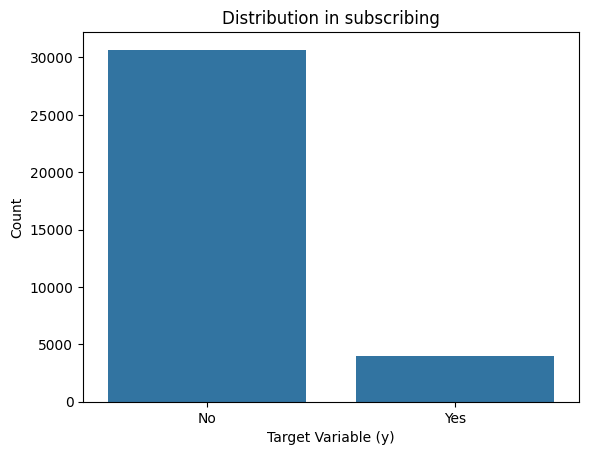

In [24]:
sns.countplot(x=y_train)
plt.title('Distribution in subscribing')
plt.xlabel('Target Variable (y)')
plt.ylabel('Count')
plt.xticks(ticks=[0, 1], labels=['No', 'Yes'])
plt.show()

From the balance of classes of the two groups it would be suitable to use an XGBClassifier model to run the predictions

              precision    recall  f1-score   support

           0       0.93      0.96      0.95      7644
           1       0.63      0.50      0.56      1027

    accuracy                           0.91      8671
   macro avg       0.78      0.73      0.75      8671
weighted avg       0.90      0.91      0.90      8671



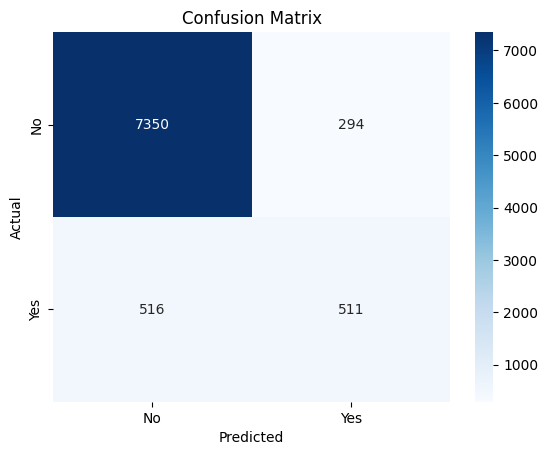

In [25]:

model = XGBClassifier(eval_metric='logloss')
model.fit(X_train, y_train)

y_pred = model.predict(X_test)
print(classification_report(y_test, y_pred))

cm = confusion_matrix(y_test, y_pred)
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=['No', 'Yes'], yticklabels=['No', 'Yes'])
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.title('Confusion Matrix')
plt.show()

From the report above, we can see that the model scores 0.56 as an f1-score and only a 50% recall for those who would subscribe which means that it misses half the people. In a marketing sense this makes the model inefficient and it may have been caused by favouring the majority class so this can be adjusted by using SMOTE and cross-val.

In [26]:

# Load data
df = pd.read_csv('bank_clean.csv')
df['y'] = df['y'].map({'no': 0, 'yes': 1})

X = df.drop('y', axis=1)
y = df['y']

X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, stratify=y, random_state=42
)

# Preprocessing in one-hot encoding categorical and numerical features
categorical_cols = X.select_dtypes(include='object').columns.tolist()
numerical_cols = X.select_dtypes(include=['int64', 'float64']).columns.tolist()

# Preprocessing: scale numericals and one-hot encode categoricals
preprocessor = ColumnTransformer(
    transformers=[
        ('num', StandardScaler(), numerical_cols),
        ('cat', OneHotEncoder(handle_unknown='ignore', sparse_output=False), categorical_cols)
    ],
    remainder='drop'  # or 'passthrough' if you still want untouched features included
)

# Pipeline with preprocessing, SMOTE, and model
pipeline = ImbPipeline(steps=[
    ('preprocess', preprocessor),
    ('smote', SMOTE(random_state=42)),
    ('classifier', XGBClassifier(eval_metric='logloss', random_state=42))
])


pipeline.fit(X_train, y_train)
y_pred = pipeline.predict(X_test)

print("Classification Report:\n", classification_report(y_test, y_pred))

c:\Users\arifu\miniforge3\envs\ml-env\lib\site-packages\sklearn\base.py:474: FutureWarning: `BaseEstimator._validate_data` is deprecated in 1.6 and will be removed in 1.7. Use `sklearn.utils.validation.validate_data` instead. This function becomes public and is part of the scikit-learn developer API.
  warnings.warn(


Classification Report:
               precision    recall  f1-score   support

           0       0.94      0.95      0.95      7985
           1       0.60      0.58      0.59      1058

    accuracy                           0.91      9043
   macro avg       0.77      0.77      0.77      9043
weighted avg       0.91      0.91      0.91      9043



This was a slight improvement however it might be that the model we've used isn't as effective as predicting and a more powerful model could be used. This could be prepared with a votingclassifier that can combine predictions from multiple models. We can use soft voting to select the highest probability and make it robust

We can also tune the classification threshold and find the one that would most improve the model

In [27]:
voting = VotingClassifier(
    estimators=[
        ('xgb', XGBClassifier(eval_metric='logloss', random_state=42)),
        ('lr', LogisticRegression(max_iter=1000)),
        ('rf', RandomForestClassifier(random_state=42)),
        ('lgbm', LGBMClassifier(random_state=42))
    ],
    voting='soft' # combines all predicted probabilities to decide
)

pipeline = ImbPipeline([
    ('preprocess', preprocessor),
    ('smote', SMOTE(random_state=42)),
    ('classifier', voting)
])

# Sets the pipeline so that the model produced above is applied after setting thresholds.
pipeline.fit(X_train, y_train)

y_proba = pipeline.predict_proba(X_test)[:, 1]

# This sets the range of thresholds that will be tried
thresholds = [i * 0.05 for i in range(1, 20)]  # 0.05 to 0.95

# set variables
best_threshold = 0.5 
best_f1 = 0

# Finds threshold that gives the best F1 score
for t in thresholds:
    y_pred_t = (y_proba >= t).astype(int)
    f1 = f1_score(y_test, y_pred_t)
    if f1 > best_f1:
        best_f1 = f1
        best_threshold = t

print(f'Best threshold: {best_threshold:.2f} F1 score: {best_f1:.4f}')

# Uses it to make final predictions
y_pred_best = (y_proba >= best_threshold).astype(int)

from sklearn.metrics import classification_report
print(classification_report(y_test, y_pred_best))



c:\Users\arifu\miniforge3\envs\ml-env\lib\site-packages\sklearn\base.py:474: FutureWarning: `BaseEstimator._validate_data` is deprecated in 1.6 and will be removed in 1.7. Use `sklearn.utils.validation.validate_data` instead. This function becomes public and is part of the scikit-learn developer API.
  warnings.warn(


[LightGBM] [Info] Number of positive: 31937, number of negative: 31937
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.062674 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 12561
[LightGBM] [Info] Number of data points in the train set: 63874, number of used features: 51
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.500000 -> initscore=0.000000


c:\Users\arifu\miniforge3\envs\ml-env\lib\site-packages\sklearn\utils\validation.py:2739: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(


Best threshold: 0.40 F1 score: 0.6221
              precision    recall  f1-score   support

           0       0.97      0.90      0.94      7985
           1       0.52      0.78      0.62      1058

    accuracy                           0.89      9043
   macro avg       0.74      0.84      0.78      9043
weighted avg       0.92      0.89      0.90      9043



This has certainly improved the accuracy of the model, especially the recall which has been raised to 73% so it only misses 27% of potential subscribers but it still has a low precision which is expected because due to smote the model is more encouraged to predict subscriptions due to the availability of values and in this case the f1-score has been maximised so this method brings the most benefit to the model overall.

PR AUC: 0.6613


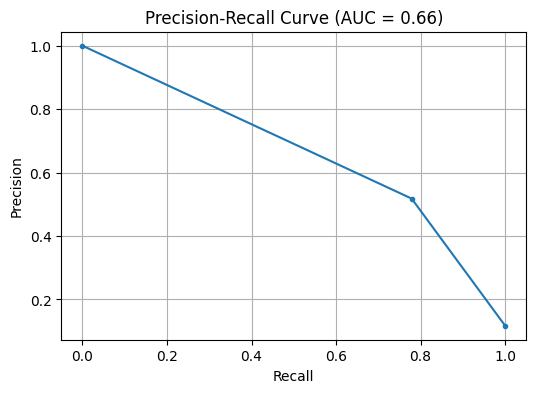

In [28]:
from sklearn.metrics import precision_recall_curve, auc

precision, recall, thresholds = precision_recall_curve(y_test, y_pred_best)
pr_auc = auc(recall, precision)
print(f"PR AUC: {pr_auc:.4f}")

plt.figure(figsize=(6, 4))
plt.plot(recall, precision, marker='.')
plt.title(f'Precision-Recall Curve (AUC = {pr_auc:.2f})')
plt.xlabel('Recall')
plt.ylabel('Precision')
plt.grid(True)
plt.show()



The PR AUC curve supports the outcome from the model above from the area under the curve and it shows that the precision decreases as recall increases since the model is more likely to pick false positives.

Some basic EDA can also be done to give us some insights into the dataset.

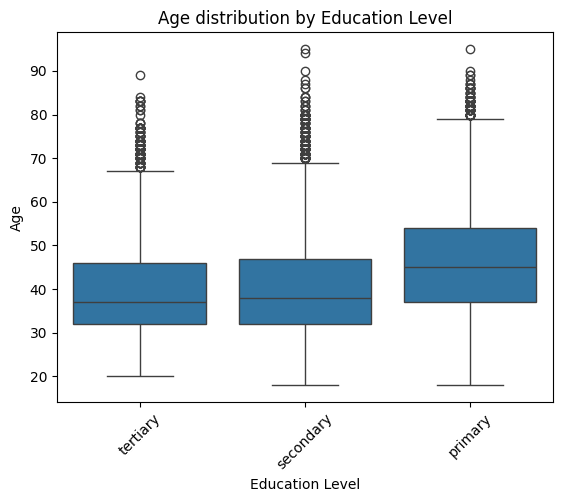

In [29]:
# Show age in each education level
sns.boxplot(x='education', y='age', data=df)
plt.title('Age distribution by Education Level')
plt.xlabel('Education Level')
plt.ylabel('Age')
plt.xticks(rotation=45)
plt.show()

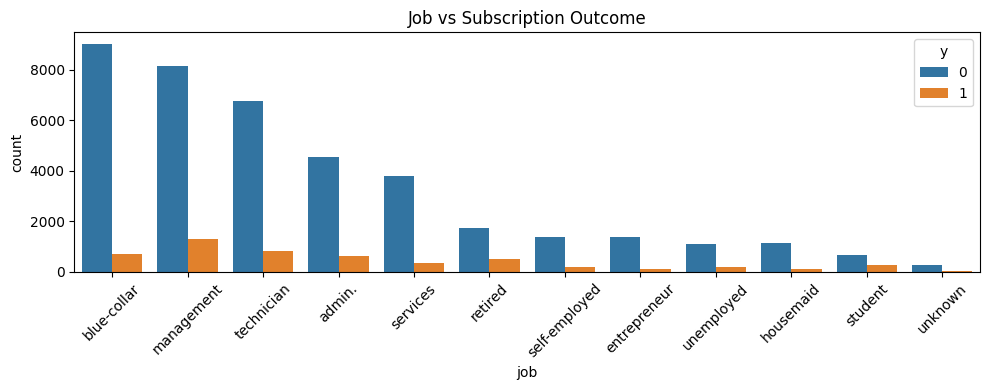

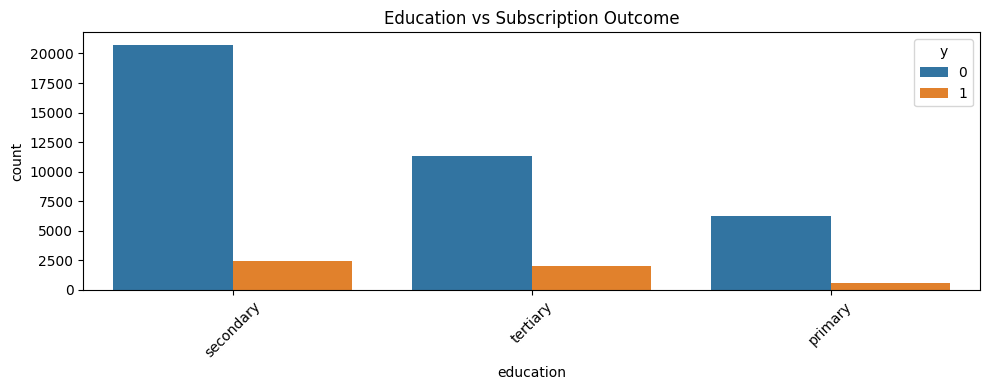

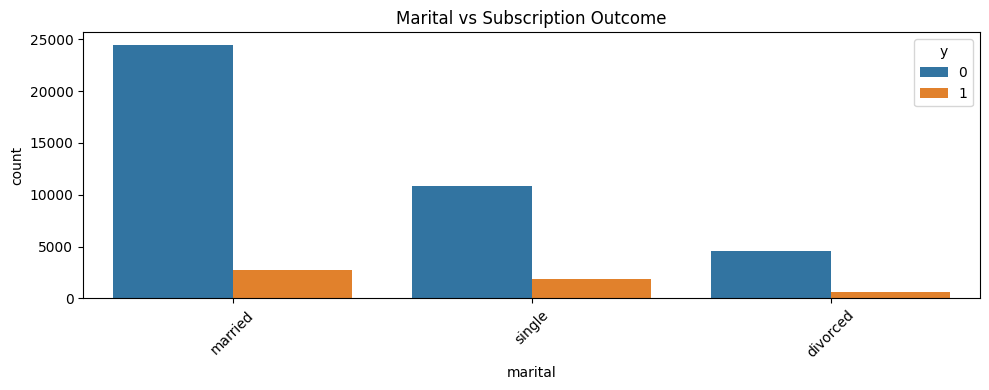

In [30]:
for col in ['job', 'education', 'marital']:
    plt.figure(figsize=(10, 4))
    sns.countplot(data=df, x=col, hue='y', order=df[col].value_counts().index)
    plt.xticks(rotation=45)
    plt.title(f'{col.title()} vs Subscription Outcome')
    plt.tight_layout()
    plt.show()


From the above graphs we can see that those who are in higher education or professions are more likely to subscribe to bank deposits, this is likely because of the level of knowledge surrounding using deposits. It also shows that those who are single are more likely to use them which is likely due to the fact that they will be able to keep up with deposits whereas married couples may be more weary due to potential unforeseen expenses.